# Strong Gravitational lensing

Strong gravitational lensing is a gravitational lensing effect that is strong enough to produce multiple images, arcs, or even Einstein rings.          

Generally, the strong lensing effect requires the projected lens mass density greater than the critical density. For point-like background sources, there will be multiple images; for extended background emissions, there can be arcs or rings. 

In this notebook I assume a point source of great mass for the lensing object, i.e. a black hole and numerically solve for the lensed images. The evaluation is performed by shifting to the relative coordinate system of the lens and then eqvaluating the lensing equations over the perimeter of an assumed circular source of a given radius in polar coordinates. The result is then plotted by shifting back to the absolute coordinate system and filling in the area between the calculated lensed image boundaries. 

Later the same calculations are performed over an image, a n-D array actually, by assuming the indices $(x,y)$ of the pixel are the coordinates of a source with zero radius. Retrieved are the lensed coordinates of that point that are then overplotted over a dark background, using the remaining dimensions of the ingoing array as pixel values, resulting in an simulated lensed image, i.e. the ingoing image as if there was a massive point source lens in front of it. 

The units are completely arbitrary.

In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.interpolate import griddata
from IPython.display import HTML

For a source with coordinates $(x, y)$ and a radius $r$:
$$\begin{eqnarray}
\beta_x &= x + r\cos\theta \\
\beta_y &= y + r\cos\theta \\
\beta &= \sqrt{\beta_x^2 + \beta_y^2}
\end{eqnarray}$$

where $0 < \theta < 2\pi$ (since sources are assumed to be unit cirlces). There are two images of the source with coordinates $(x_1, y_1)$ and $(x_2, y_2)$ given by:

$$\begin{eqnarray}
x_i' &= \frac{\beta\pm\sqrt{\beta^2 + 4r_E^2}}{2}\cos\gamma \\
y_i' &= \frac{\beta\pm\sqrt{\beta^2 + 4r_E^2}}{2}\sin\gamma
\end{eqnarray}$$

where $\gamma = \arctan{\beta_y/\beta_x}$.

In [2]:
def simulate_lensing(source, lens, step=None, **kwargs):
    """Given positions and radii of the source and the lens calculates
    the lensed images and returns points on their outlines. 
    
    Parameters
    -----------
    source : `dict`
        dictionary describing the 'x', 'y' coordinates of the source
        and its radius 'r'
    lens : `dict'
        dictionary describing the 'x', 'y' coordinates of the lensing
        source and its Einstein radius 'rE'
    step : `float` or `None`
        When `None` step is determined automatically as the 
        min(0.0001, d/1e4) where d is distance between the source and 
        the lens. 
        
    Returns
    -------
    srcimg : `np.array`
        Array of points sampled around the perimeter of the source.
    img1 : `np.array`
        Array of points sampled around the perimeter of the first lensed
        image.
    img2 : `np.array`
        Array of points sampled around the perimeter of the second lensed
        image.
    er : `np.array`
        Array of points sampler around the perimeter defined by the 
        Einstein radius. 
    """
    dist = np.sqrt( (source['x']-lens['x'])**2 + (source['y']-lens['y'])**2 )
    dist = 1 if dist < 1e-4 else dist
    step = min(dist, 0.0001) if step is None else step
    theta = np.arange(0, 2*np.pi, step)
    
    # to have an absolutely positioned lens, first we translate the 
    # coordinate system origin to lens position
    beta_x = source['x'] + source['r']*np.cos(theta) - lens['x']
    beta_y = source['y'] + source['r']*np.sin(theta) - lens['y']
    beta = np.sqrt(beta_x**2+beta_y**2)
    
    th1 = 0.5*( beta + np.sqrt(beta**2 + 4*lens['rE']**2) )
    th2 = 0.5*( beta - np.sqrt(beta**2 + 4*lens['rE']**2) )
    
    gamma = np.arctan2(beta_y, beta_x)
    
    cosg = np.cos(gamma)
    tmp1x = th1*cosg
    tmp2x = th2*cosg

    sing = np.sin(gamma)
    tmp1y = th1*sing
    tmp2y = th2*sing

    # and then we return back to the absolute coord. system
    srcimg = {"x":beta_x+lens['x'], "y":beta_y+lens['y']}
    img1 = {"x":tmp1x+lens['x'], "y":tmp1y+lens['y']}
    img2 = {"x":tmp2x+lens['x'], "y":tmp2y+lens['y']}
    er = {"x":lens['rE']*np.cos(theta)+lens['x'], 
          "y":lens['rE']*np.sin(theta)+lens['y']}
    
    return srcimg, img1, img2, er

Plotting utilities can be a bit complicated, especially because we are returning collections of points on the perimeter of the source, lens and images. 

Plotting issues arise when the source first touches the lens. Outside of that distance one can use `matplotlib.pyplot.fill` method since `simulate_lensing` returns points around the perimeter. Within this distance, however, fill would not produce physical results.

When the source touches the lens the lensed images become internally intersecting circles, i.e. e distance between the centers of the circles is equal to the difference of their radii. The fill method then fills insides of the images, but the corresponding physical effect is the so-called Einstein ring. So we need to fill the area in between the cirlces. The function to use then is `matplotlib.pyplot.fill_between`. 

But then, again, due to the inner-workings of `matplotlib.pyplot.fill_between` this doesn't really work that well, so we need to add the missing bits via `matplotlib.pyplot.fill_betweenx`. Even then the result will not exactly also be physical unless we always fill in both images, as they will work complementary with each other to produce an Einstein ring.

We keep track and return drawn artists so that we could animate the lens.

In [3]:
def plot_lens(src, lens={"x":0.0, "y":0.0, "rE":2.0}, ax=None, title="", 
              colors={'src':'black', 'img1':'darkgray', 'img2':'darkgray', 'lens':'red'},
              **kwargs):
    """Given an source and optionally an axis and lens too, simulates 
    lensing  and plots the results. 
    
    Parameters
    ----------
    src : `dict`
        dictionary describing the 'x', 'y' coordinates of the source
        and its radius 'r'
    lens : `dict'
        dictionary describing the 'x', 'y' coordinates of the lensing
        source and its Einstein radius 'rE'        
    ax : `matplotlib.pyplot.Axes` or `None`
        Axis on which the plot will be made. If `None` a new figure
        is created. 
        
    Returns
    -------
    ax : `matplotlib.pyplot.Axes`
        Axis on which the plot will be made.
    artists : `list`
        List of Collections (Artists) that were plotted. Required for
        ArtistAnimation
    """
    srci, img1, img2, erad = simulate_lensing(src, lens, **kwargs)
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(10, 10))
        plt.legend(loc='upper right')

    # this is safe everytime otherwise circles look like elipses
    ax.set_aspect('equal')
    if title:
        ax.set_title(title)
    
    # neccessary trick to, at least approximately, match the visual to the physical
    dist = np.sqrt( (src['x']-lens['x'])**2 + (src['y']-lens['y'])**2 )
    artists = []
    if dist<=src['r']:
        artists.append( ax.fill_between( img1['x'], img1['y'], -img2['y'], color=colors['img1']) )
        artists.append( ax.fill_betweenx(img1['y'], img1['x'], -img2['x'], color=colors['img1']) )
        artists.append( ax.fill_between( img2['x'], img2['y'], -img1['y'], color=colors['img2']) )
        artists.append( ax.fill_betweenx(img2['y'], img2['x'], -img1['x'], color=colors['img2']) )
    else:
        artists.append(ax.fill(img1['x'], img1['y'], color=colors['img1'])[0])
        artists.append(ax.fill(img2['x'], img2['y'], color=colors['img2'])[0])

    lenplt = ax.plot(lens['x'], lens['y'], color=colors['lens'], marker='x', linestyle=None, label="lens")
    eraplt = ax.plot(erad['x'], erad['y'], color=colors['lens'], marker=',', linestyle='--', label="Einstein radius")
    srcplt = ax.fill(srci['x'], srci['y'], color=colors['src'], linestyle=None, label="source")

    # we do not append lens and Einstein radius to the list of artists as it's assumed
    # they doesn't move and we waste precious cycles redrawing them. If they are animated
    # uncomment the next two lines:
    #artists.append(lensplt[0])
    #artists.append(eraplt[0])
    artists.append(srcplt[0])
    
    return ax, artists

Do some simple theoretical plotting, as an animation of course so I can look cool:

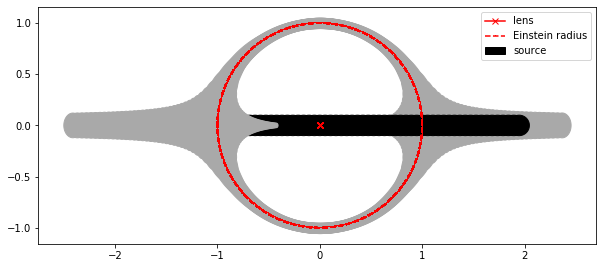

In [4]:
source = {"r":0.1, 'y':0}
lens={"x":0.0, "y":0.0, "rE":1.0}
ranges = (-lens['rE']-1, lens['rE']+1) 
step = lens['rE']/19.0

figu, axu = plt.subplots(1,1, figsize=(10, 10))
artists = []
for x in np.arange(*ranges, step):
    source['x'] = x
    ax, ars = plot_lens(source, lens, step=0.001, ax=axu)
    artists.append(ars)
    
    # plot legend only once to avoid entry duplication
    if x == -lens['rE']-1:
        plt.legend(loc='upper right')

In [5]:
anim = animation.ArtistAnimation(figu, artists, interval=100, blit=True)
HTML(anim.to_html5_video())

## Lensing images

It's all the same math as in #1 except all $r$ values are zero so we lose all those terms, and sources are not assumed to be circles so we can drop the $\theta$ too. First, pick a cool image and write some image drawing utilities:

In [6]:
def showimg(img, ax=None, lens=None, figsize=(10, 10), title='', interp='none'):
    """Displays an image. 
    
    Parameters
    ----------
    img : `np.array`
        Image to display, an numpy 2D array or numpy ndarray with shapes
        of (nx, ny, 3) or (nx, ny, 4). 
    ax : `matplotlib.pyplot.Axes` or `None
        If `None` a new figure and axis are created on which to draw. 
        Otherwise image is displayed on the given axis.
    lens : `dict` or `None`
        A dictionary containing coordinates 'x', 'y' and Einstein radius 
        'rE' of the lens or `None`. If given an 'X' is drawn at location 
        of the lens and the outline of the Einstein radius is drawn. 
    figsize : `tuple`
        Figure size, by default (10, 10). 
    interp : `str`
        Interpolation that will be used to display the image. By defualt `none`.
        
    Note
    ----
    Matplotlib imshow clipping warnigns are suppressed. 
    """
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.set_title(title)
        
    if lens is not None:
        ax.scatter(lens['x'], lens['y'], marker='x', s=100, color="white")
        theta=np.linspace(0,2*np.pi,1000)
        er = {"x":lens['rE']*np.cos(theta)+lens['x'], 
              "y":lens['rE']*np.sin(theta)+lens['y']}
        ax.plot(er['x'], er['y'], color='w', marker=',', linestyle='--', label="Einstein radius")
 
    # apparently jupyter notebook can't stop warnings...?
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", module='matplotlib')
        implt = ax.imshow(img, interpolation=interp)
    
    return implt

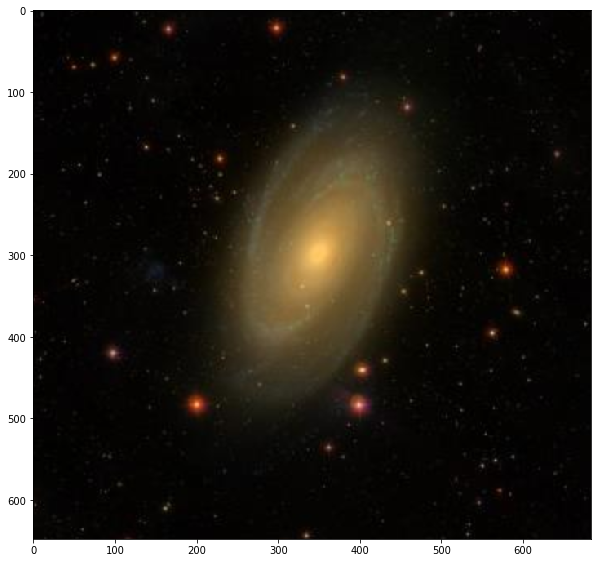

In [7]:
image = plt.imread('distant_galaxies.png')
showimg(image)

Same for images as for unit circles:
   * translate the coordinate system origin 
   * calculate beta (this time object radius is zero however)
   * calculate thetas
   * calculate points to which original position are mapped to
   * shift back to absolute coordinate system
   
The extra step that is different is: 
   * deal with numerical instability and roundoff errors
   
The extra step is neccessary because source positions are pixel indices, i.e. gridded numbers. Applying `atan2`, `sin`, `cos`, zero radius assumption and other roundoff errors cause a lot of aliasing effects. The proper solution is to not use the indices as position but preform the calculation in real space and then convolve with some kind of pixelation kernel that adds the contributions of a source to, potentially, many pixels or the opposite: a contribution of many sources to a single pixel. 

Since that can get very complicated, the simpler answer is to fake it a little. The best place to do that is =aAfter calculating the mapped points and before returning to absolute coord system (since that is the step in which most roundoff errors happen). The best way to do that is to interpolate between the mpped points coordinates using colors as values measured in those points. 

The best way to imagine why that works is to imagine pixels as buckets in which we have discretely measured some underlying real image. Then the centers of the buckets become points in which we discretely measured the flux in `r`, `g` and `b` band. The best way to remove aliasing and roundoff error effects is to not sample the end image in the same aliased points we produced. But the only way to do that is if we know the values in-between some of the measurement points (buckets/pixles). The only way do know that however is to make an reasonable educated guess - thta is interpolate. The mapped position coordinates can thus be used as a grid of points in which we have sampled the values of a function (pixel color data) and we can interpolate in-between the rest. 

Best tool for the job is `scipy.griddata`, since due to the nature of gravitational lensing this point grid does not need to be evenly spaced. 

There are three different implementations of the procedure described above: the naive implementation that displays all kinds of numerical instability effects, the better approximation scheme that smooths over the numerical instability effects by interpolating over them and the default implementation that will interpolate directly from raw data. 

The better approximation scheme does the exact same thing as the default implementation - except the data source is the already binned image. The key trick there is to not take the zero-valued pixels (the artefacts) into consideration as samples. Then the interplator will have to produce values for those pixels. This is, of course, more performant than interpolating from point maps, but will suffer from some artefacts if the threshold isn't set quite right. Also, the ingoing data is already wrong, so it'll look like a duck and quack like a duck, but is probably only 90% of a duck. 

In [8]:
def lens_image(img, lens='center', brightnessThresh=-1, interpThresh=0.03, method='raw'):
    """Given an input image and a lens parameters simulates what we would observe if 
    that lens were between us and all the objects in the image. Implements 3 different
    schemes to produce the end image: approx, better approx and default. 
    
    The different schemes differ in the quality of the result and performance with the
    fastest but worst quality scheme being approx. Better approx attempts to interpolate
    over the artefacts in approx while default scheme interpolates the end image directly
    from the mapped data.
    
    Parameters
    ----------
    img : `np.array`
        Image, an numpy 2D array or numpy ndarray with shapes of (nx, ny, 3) or
        (nx, ny, 4). 
    lens : `dict` or `str`
        Dictionary specifying the lens coordinates ('x', 'y') in pixel space and
        an Einstein radius 'rE'. Otherwise if a string `center` is given the lens
        is placed in the middle of the image and it's Einstein radius is set to be
        1/10th of the length of the shorter axis of the image.
    brightnessThresh : `float`
        brightness threshold under which the object will not be considered to be a 
        source, i.e. no mapping to warped coordinates would happen. By default set 
        to -1 to include all pixels.
    interpThresh : `float`
        interpolation threshold applied in the better approximation method only.
        Interpolation is performed only for mapped pixels which brightness is greater
        than this values. Should be higher than the artefacts and image zero value but
        not high enough to produce image artefacts itself. By default 0.03.
    method : `str`
        Method to use. The default one is to interpolate from the original map. The 
        `approx` method will perform a naive rounding off and gridding of the map, while
        any concatenation of `better` and `approx` will invoke the scheme in which end 
        result is obtained by interpolating over image artefacts.
    """
    dimx, dimy, *extradims = img.shape
    if lens == 'center':
        lens = {'x':int(dimx/2), "y":int(dimy/2), "rE":int(min(dimx, dimy)/10)}

    # grab only bright enough objects, save orig. colors before losing indexing info.
    bwimg = np.average(image[:,:,:3], axis=2)
    srcx, srcy = np.where(bwimg > brightnessThresh)
    colors = img[srcx, srcy, :3]

    srcx -= lens['x']
    srcy -= lens['y']
       
    beta_x = srcx 
    beta_y = srcy 
    gamma = np.arctan2(beta_y, beta_x)
    
    beta = np.sqrt(srcx**2 + srcy**2)

    th1 = 0.5*( beta + np.sqrt(beta**2 + 4*lens['rE']**2) )
    th2 = 0.5*( beta - np.sqrt(beta**2 + 4*lens['rE']**2) )
    
    cosg = np.cos(gamma)
    tmp1x = th1*cosg + lens['x']
    tmp2x = th2*cosg + lens['x']

    sing = np.sin(gamma)
    tmp1y = th1*sing + lens['y']
    tmp2y = th2*sing + lens['y']

    # from here onwards we deviate from simulate_lensing
    if 'approx' in method:
        # The correct way to do it is to convolve with a pixelating grid + other effects. 
        # even just np.around(*).astype(int) is better than .astype(int)
        x1_converted = tmp1x.astype(int)
        y1_converted = tmp1y.astype(int)
        x2_converted = tmp2x.astype(int)
        y2_converted = tmp2y.astype(int)
    
        maxx = int(np.max((x1_converted, x2_converted)))
        maxy = int(np.max((y1_converted, y2_converted)))
    
        # all indexing info has been lost by now anyhow so why not pad by 1 for safety
        warped = np.zeros((maxx+1, maxy+1, 3))
        warped[x1_converted, y1_converted] = colors  
        warped[x2_converted, y2_converted] = colors

        if 'better' in method:
            ix, iy, *extra = np.where(warped[:, :]>interpThresh)
            samples = warped[ix, iy]
            # note the flipped x and y since imshow will transpose
            X, Y = np.meshgrid(np.arange(0,  warped.shape[1], 1), np.arange(0, warped.shape[0], 1))
            warped = griddata((iy, ix), samples, (X, Y), method='cubic')
        return warped
    
    # if non-approx methods are used, interpolate from raw data directly, transpose
    xcoor = np.arange(0,  dimy, 1)
    ycoor = np.arange(0,  dimx, 1)
    X, Y = np.meshgrid(xcoor, ycoor)
    
    # img1 is the image outter to Einstein radius, img2 is the 
    # image inner to the Einstein radius. They have incorrect sollutions 
    # outside those areas. Combination is the full solution. 
    img1 = griddata((tmp1y, tmp1x), colors, (X, Y), method='cubic')
    img2 = griddata((tmp2y, tmp2x), colors, (X, Y), method='cubic')
    img1[~np.isnan(img2)] = img2[~np.isnan(img2)]
    
    return img1

The three approximative schemes produce the following results:

In [9]:
lens={"x":300, 'y':300, "rE":50}

CPU times: user 469 ms, sys: 39.7 ms, total: 509 ms
Wall time: 139 ms


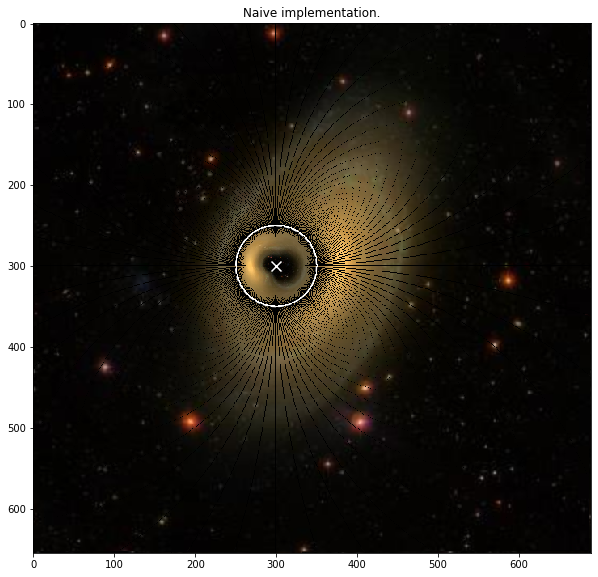

In [10]:
%%time
warped_approx = lens_image(image, lens, method='approx')
i = showimg(warped_approx, lens=lens, title="Naive implementation.")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 4.01 s, sys: 109 ms, total: 4.12 s
Wall time: 3.26 s


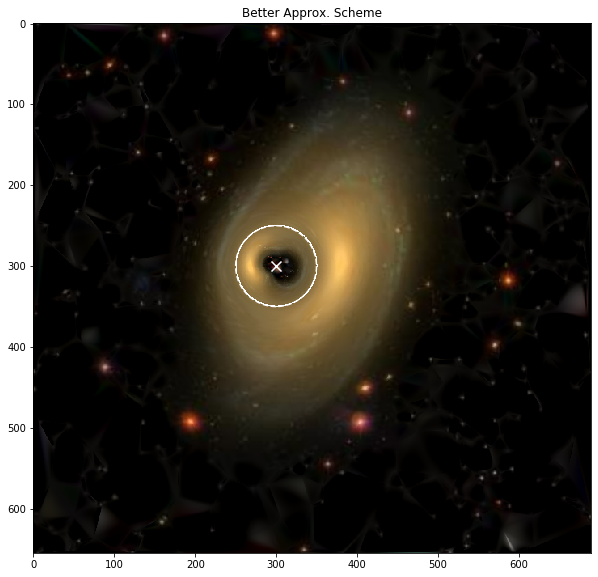

In [11]:
%%time

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

warped_better = lens_image(image, lens, interpThresh=0.05, method='better approx')
i = showimg(warped_better, lens=lens,  title="Better Approx. Scheme")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 12.8 s, sys: 35.9 ms, total: 12.8 s
Wall time: 12.1 s


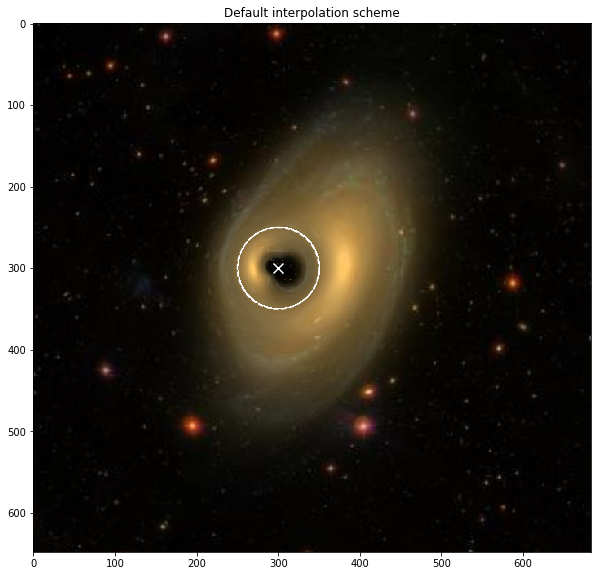

In [12]:
%%time
warped = lens_image(image, lens)
i = showimg(warped, lens=lens, title="Default interpolation scheme")

Of course we are cool beans so we'll use only the best scheme to produce the end animated figure.

In [44]:
%%time
warps, lenses = [], []
for x, y in zip(range(100, 550, 5), range(100, 550, 5)):
    lens = {"x":x, 'y':y, "rE":50}
    lenses.append(lens)
    warps.append(lens_image(image, lens))

CPU times: user 17min 47s, sys: 6.2 s, total: 17min 53s
Wall time: 17min 5s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


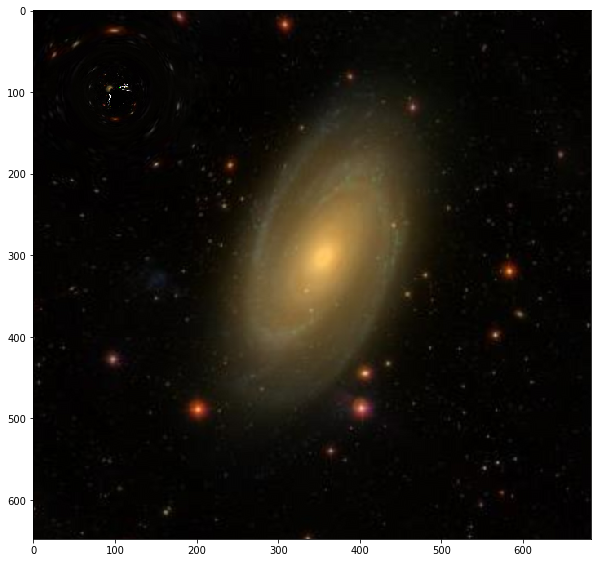

In [45]:
from matplotlib import animation

fig, ax = plt.subplots(1,1, figsize=(10, 10))
snaps =  warps
im = plt.imshow(snaps[-1], interpolation='none')

def animate_func(i):
    im.set_array(snaps[i])
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames=len(snaps), interval=100)
HTML(anim.to_html5_video())